In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

### Read .csv file from data cleaning notebook

In [2]:
df = pd.read_csv('../data/comb_clean_pitcher.csv', index_col=False)

In [3]:
df.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - SL - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,SL,5,0,1,0,0,9.0 - FB - called,14.0 - SL - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - SL - ball,9.0 - FB - called,14.0 - SL - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - CH - ball,14.0 - CH - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,CH,5,0,1,0,0,3.0 - FB - foul,14.0 - CH - ball,14.0 - CH - ball,2-2


- Dropping any specific data point that may be causing issues, 4-2 is not a valid `pitch_count` for our dataset

In [4]:
df_bi = df.drop(df[df['pitch_count'] == '4-2'].index)

- Remove any null values

In [5]:
df_bi.dropna(axis=0, inplace=True)

In [6]:
#Sanity Check
df_bi.isna().sum()

player_name            0
pitcher                0
batter                 0
stand                  0
pitch_type             0
pitch_number           0
outs_when_up           0
times_faced            0
XBH                    0
large_score_dif        0
recent_pitch           0
second_recent_pitch    0
third_recent_pitch     0
pitch_count            0
dtype: int64

### Need to transform pitches from multiclass to binary with functions. 

In [7]:
def transform_pitch_types(column):
    """
    Transform specific pitch types in a column to 'OS'.
    'SL', 'CH', 'CB' are changed to 'OS', other values are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    # Mapping specific pitch types to 'OS'
    pitch_map = {'SL': 'OS', 'CH': 'OS', 'CB': 'OS'}

    # Using the map function to apply the transformation
    return column.map(lambda x: pitch_map.get(x, x))

In [8]:
def transform_pitch_types_in_string(column):
    """
    Transform specific substrings in a column to 'OS'.
    Substrings 'SL', 'CH', 'CB' are changed to 'OS', other parts of the string are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    def replace_substring(pitch):
        # Replace specific substrings with 'OS'
        for sub in ['SL', 'CH', 'CB']:
            pitch = pitch.replace(sub, 'OS')
        return pitch

    return column.apply(replace_substring)

- Making a new copy of the data before setting target and features

In [9]:
df_bi_clean = df_bi.copy()
df_bi_clean['pitch_type'] = transform_pitch_types(df_bi_clean['pitch_type'])
df_bi_clean['recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['recent_pitch'])
df_bi_clean['second_recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['second_recent_pitch'])
df_bi_clean['third_recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['third_recent_pitch'])

- Data for `pitch_type` column should now be split into binary classes, **FB** for fastball **OS** for offspeed.

In [10]:
#Sanity Check
df_bi_clean.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - OS - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,OS,5,0,1,0,0,9.0 - FB - called,14.0 - OS - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - OS - ball,9.0 - FB - called,14.0 - OS - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - OS - ball,14.0 - OS - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,OS,5,0,1,0,0,3.0 - FB - foul,14.0 - OS - ball,14.0 - OS - ball,2-2


#### Set target variable and columns to include before training and splitting the data

In [11]:
X = df_bi_clean.drop(columns=['player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_number'])
y = df_bi_clean['pitch_type']

#### Initialize OneHotEncoder and perform `train_test_split`

In [12]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

# Split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Create dummy model

In [13]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')

In [14]:
# fit dummy model
dc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
#Score for dummy model
dc.score(X_test, y_test)

0.540991461927165

- Create a `ColumnTransformer` to encode all categorical columns before we create pipeline for Modeling and Evaluation

In [16]:
from sklearn.compose import ColumnTransformer

# Create a column transformer to apply encoding only to the categorical columns
preprocessor = ColumnTransformer(transformers=
                                 [('cat', ohe, [0, 1, 2, 3, 4, 5, 6, 7, 8])],
                                 remainder='passthrough')

In [17]:
preprocessor.fit(X_train)

preprocessor.transform(X_train).shape

(68866, 333)

In [18]:
X_train_transformed = preprocessor.transform(X_train)

In [19]:
preprocessor.transform(X_test).shape

(22956, 333)

## We will create a pipeline for MLPClassifier, A neural network from sklearn

In [20]:
from sklearn.neural_network import MLPClassifier

#Build pipeline to train MLP
pipe = Pipeline([('ct', preprocessor), ('mlp', MLPClassifier())])

- We opted to use `RandomizedSearchCV` here instead of `GridSearchCV` that we used in our other training runs. Random search will look for the best hyperparameters that we set in the distribution. MLPclassifier has hidden layers that we can't really interpret but we use the funnel stucture with 3 layers that starts and end with smallest layers eg. (10, 30, 10)

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'mlp__hidden_layer_sizes': [(10,30,10), (50,100,50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['sgd'],
    'mlp__alpha': [0.0001, .001],
    'mlp__tol': [1e-4, 1e-5, 1e-6]
}

# Create a RandomizedSearchCV object
clf = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, n_iter=50, verbose=3, cv=5, random_state=42, n_jobs=-1)

# Fit the model
clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/dreampy/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 out of 120 | elapsed:  8.2min remaining:   25.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  8.4min finished
/home/dreampy/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


NameError: name 'best_parametbers' is not defined

- Print the best parameters and best score for our RandomizedSearch

In [23]:
# Get the best parameters and score
best_parameters = clf.best_params_
best_score = clf.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Parameters: {'mlp__tol': 1e-06, 'mlp__solver': 'sgd', 'mlp__hidden_layer_sizes': (50, 100, 50), 'mlp__alpha': 0.001, 'mlp__activation': 'tanh'}
Best Score: 0.6001801145206891


- Generate `classification_report` we are looking at **accuracy** here for our pitch predicition. 

In [26]:
from sklearn.metrics import classification_report

# Step 2: Make Predictions
y_pred = clf.predict(X_test)

# Step 3: Generate Classification Report
report = classification_report(y_test, y_pred)

In [28]:
print(report)

              precision    recall  f1-score   support

          FB       0.62      0.68      0.65     12419
          OS       0.57      0.50      0.53     10537

    accuracy                           0.60     22956
   macro avg       0.59      0.59      0.59     22956
weighted avg       0.60      0.60      0.59     22956



- Display ConfustionMatrix for our binary classes. 

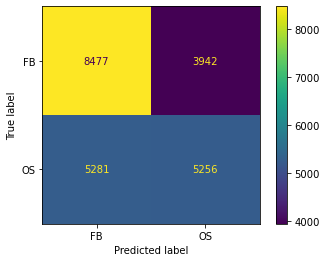

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Make predictions
y_pred = clf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve

# clf is our classifier and it supports predict_proba()
y_score = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

# Compute and plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_pipe = Pipeline([('ct', preprocessor), ('rf', RandomForestClassifier())])

In [ ]:
grid_search_rf = {'rf__max_depth': [None, 25, 35],
       'rf__class_weight': ['balanced', 'balanced_subsample']}

In [ ]:
rf_pipe = GridSearchCV(estimator=rf_pipe, param_grid=grid_search_rf, verbose=3, n_jobs=-1)
rf_pipe.fit(X_train, y_train)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf_pipe is your trained GridSearchCV object
best_rf = rf_pipe.best_estimator_

# Access the ColumnTransformer from the pipeline
# Replace 'preprocessor_name' with the actual name of your ColumnTransformer step
column_transformer = best_rf.named_steps['ct']

# Get the feature names after one-hot encoding and any 'passthrough' features
encoded_feature_names = column_transformer.get_feature_names()

# Extract feature importances
importances = best_rf.named_steps['rf'].feature_importances_

# Create a pandas Series with the importances and encoded feature names
feature_importances = pd.Series(importances, index=encoded_feature_names)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=True)

n = 10  # for example, the top 20 features
top_sorted_importances = sorted_importances.head(n)


# Create a horizontal bar plot
plt.figure(figsize=(20,12))  # You may need to adjust the figure size to fit your screen
top_sorted_importances.plot(kind='barh')  # 'barh' creates a horizontal bar plot
plt.title('Top Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()
plt.savefig('feature_importances_2024.png', dpi=300);